<h1><bold>
<hr style="border-width:2px;border-color:#1664c8">
Partie <b>4</b><br>
    <center>Identification de langue avec un modèle de <b>Deep Learning</b> et<br>
    un BOW en input</center>

<div style="text-align: right;">Version 1</div><br>
<hr style="border-width:2px;border-color:#1664c8">
</h1></bold>

## **Identification de langue avec le Deep Learning et**
## **le Bag Of World en input**

In [6]:
import pandas as pd
import random
import joblib
from sklearn.metrics import accuracy_score, classification_report

# Choix de la Tokenisation (False = BERT, True Tiktoken)
titoken_tokenization = True

## Pour résoudre les problème de mémoire et de performances
nb_token_max = 8000
nb_phrase_lang = 8000 # 40000
import warnings
warnings.filterwarnings('ignore')

#### Lectures des phrases et de leur étiquette "Langue" pour les langues sélectionnées

In [7]:
# Ouvrir le fichier d'entrée en mode lecture
def create_lang_df(path):
    df = pd.read_csv(path, index_col ='id')
    return df

df_big = create_lang_df('../data/multilingue/sentences.csv')
lan_code = ['eng','fra','deu','spa','ita']
df = pd.DataFrame(columns=df_big.columns)
for i in range(len(lan_code)):
    df= pd.concat([df, df_big[df_big['lan_code']==lan_code[i]].iloc[:nb_phrase_lang]])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
n_rows = len(df)
print('Nombre de lignes de sentence.csv:',n_rows)

from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()
df['lan_code'] = encoder.fit_transform(df['lan_code'])

df

Nombre de lignes de sentence.csv: 40000


,lan_code,sentence
0,3,È occupata come Tom.
1,0,Der Wissenschaftler will den Daten einen Sinn ...
2,4,Lo verás.
3,1,What kind of ship is that?
4,4,Tu maravillosa conferencia fue como arrojar pe...
...,...,...
39995,1,He did not speak at all.
39996,2,Elles partagent un élément commun.
39997,3,Quanto cazzo è vero!
39998,1,Is he aware of the difficulty?


#### Réalisation d'un jeu de données d'entrainement et de test

In [9]:
# créer 2 dataframes: 1 train (70% des phrases) et 1 test (30% des phrases)
n_train = int(n_rows*0.7)
df_train = df.iloc[:n_train].sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df.iloc[n_train:].sample(frac=1, random_state=24).reset_index(drop=True)
pd.set_option('display.max_colwidth', 150)
display(df_train)
nb_phrases_lang =[]
for l in range(len(lan_code)):
    nb_phrases_lang.append(sum(df_train['lan_code']==l))
nb_phrases_lang

,lan_code,sentence
0,3,Generalmente agli studenti piace un insegnante che capisce i loro problemi.
1,0,All unsere Versuche sind fehlgeschlagen.
2,4,¿Es suficiente con 10 mil yenes?
3,1,Tom couldn't possibly have done what you claimed he did.
4,2,Tom courut à la porte.
...,...,...
27995,3,Nancy è la più bella delle quattro ragazze.
27996,4,¿Quién es este?
27997,1,The car was carrying 4 people when it had the accident.
27998,2,Je crains de ne pas être disponible.


[5548, 5601, 5605, 5619, 5627]

#### Selection du tokenizer

In [10]:
# Selection du tokenizer
if titoken_tokenization:
    import tiktoken
    tokenizer = tiktoken.get_encoding("cl100k_base")
else:
    from transformers import BertTokenizerFast
    tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-uncased')

#### Tokenisation des données sélectionnées

In [11]:
from collections import Counter
import pickle

def save_dict_token(dict_ids):
    with open('../data/dict_token', 'wb') as fichier:
        pickle.dump(dict_ids, fichier)

def load_dict_token():
    with open('../data/dict_token', 'rb') as fichier:
        dict_ids = pickle.load(fichier)
        # Définition d'une liste 'écrite' des tokens
        decoded_keys = [tokenizer.decode([key]) for key in list(dict_ids.keys())]
    return dict_ids, decoded_keys

# Création d'un dictionnaire de complet des Token ID à partir des phrases selectionnée
dict_ids = Counter(token for ligne in df['sentence'] for token in tokenizer.encode(ligne))

# Tri des token en fonction de leur fréquence
dict_ids= sorted(dict_ids.items(), key=lambda x: x[1], reverse=True) 
print("Nombre de tokens avant plafonnement:",len(dict_ids))
print("Nombre de tokens après plafonnement:",min(len(dict_ids),nb_token_max))

# Limitation du nombre de token
dict_ids = dict(dict_ids[:nb_token_max])
# save_dict_token(dict_ids)

# Définition d'une liste 'écrite' des tokens
decoded_keys = [tokenizer.decode([key]) for key in list(dict_ids.keys())]
print("Liste des 50 tokens les plus fréquents:",decoded_keys[:50])

Nombre de tokens avant plafonnement: 19900
Nombre de tokens après plafonnement: 8000
Liste des 50 tokens les plus fréquents: ['.', ',', ' a', '?', ' de', ' la', ' que', 'Tom', ' un', ' the', ' in', 'I', ' to', "'", ' le', 'i', ' es', ' en', 'é', ' l', ' ist', '!', 'Ich', ' Tom', ' me', 'o', ' pas', 'Je', ' di', ' nicht', ' is', ' à', ' you', ' el', ' d', 'a', ' una', ' die', 'en', ' est', ' ne', ' se', ' of', ' no', ' è', ' du', '¿', "'t", ' der', ' n']


#### Création d'un Bag Of Worlds

In [12]:
import numpy as np

# Créez un DataFrame BOW avec les phrases (lignes) et les fréquences de chaque token (colonnes)
def create_BOW(data):
    BOW = []
    for ligne in data:
        l_tokenised = tokenizer.encode(ligne)
        BOW.append([l_tokenised.count(token) for token in dict_ids])
    BOW = np.array(BOW).astype(float)
    return BOW
            
X_train = create_BOW(df_train['sentence'])
y_train = np.array(df_train['lan_code'].values.tolist())

#
X_test = create_BOW(df_test['sentence'])
y_test = np.array(df_test['lan_code'].values.tolist())


In [15]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

inputs = Input(shape = (nb_token_max), name = "Input")

dense1 = Dense(units = (nb_token_max), activation = "tanh", kernel_initializer='glorot_uniform', name = "Dense_1")
dense2 = Dense(units = nb_token_max, activation = "tanh", kernel_initializer='glorot_uniform', name = "Dense_2")
dense3 = Dense(units = (nb_token_max/2), activation = "tanh", kernel_initializer='glorot_uniform', name = "Dense_3")
dense4 = Dense(units = (nb_token_max/4), activation = "tanh", kernel_initializer='glorot_uniform', name = "Dense_4")
dense5 = Dense(units = len(lan_code), activation = "softmax", kernel_initializer='glorot_uniform', name = "Dense_5")

In [16]:
x=dense1(inputs)
x=dense2(x)
x=dense3(x)
x=dense4(x)
outputs=dense5(x)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 8000)]            0         
                                                                 
 Dense_1 (Dense)             (None, 8000)              64008000  
                                                                 
 Dense_2 (Dense)             (None, 8000)              64008000  
                                                                 
 Dense_3 (Dense)             (None, 4000)              32004000  
                                                                 
 Dense_4 (Dense)             (None, 2000)              8002000   
                                                                 
 Dense_5 (Dense)             (None, 5)                 10005     
                                                                 
Total params: 168,032,005
Trainable params: 168,032,005
Non-t

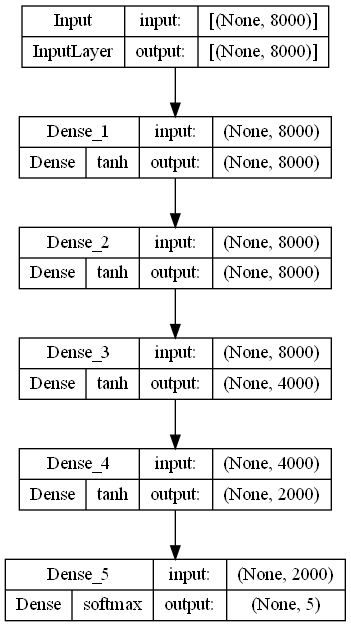

In [17]:
from PIL import Image
from tensorflow.keras.utils import plot_model

model = Model(inputs = inputs, outputs = outputs)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True,rankdir='TB')

In [10]:
#from tensorflow.keras.optimizers import Adam
# optimizer = Adam(learning_rate=0.0000000001)

model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])


In [11]:
import keras

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
model.fit(X_train,y_train,epochs=50,batch_size=64,validation_split=0.1, callbacks=[stop_early])

Epoch 1/50
394/394 [==============================] - 13s 31ms/step - loss: 0.3006 - accuracy: 0.9568 - val_loss: 0.0815 - val_accuracy: 0.9779
Epoch 2/50
394/394 [==============================] - 12s 30ms/step - loss: 0.0310 - accuracy: 0.9918 - val_loss: 0.0433 - val_accuracy: 0.9904
Epoch 3/50
394/394 [==============================] - 12s 30ms/step - loss: 0.0148 - accuracy: 0.9954 - val_loss: 0.0387 - val_accuracy: 0.9925
Epoch 4/50
394/394 [==============================] - 12s 30ms/step - loss: 0.0160 - accuracy: 0.9959 - val_loss: 0.0558 - val_accuracy: 0.9893
Epoch 5/50
394/394 [==============================] - 12s 30ms/step - loss: 0.0151 - accuracy: 0.9964 - val_loss: 0.0770 - val_accuracy: 0.9889
Epoch 6/50
394/394 [==============================] - 12s 30ms/step - loss: 0.0129 - accuracy: 0.9965 - val_loss: 0.0860 - val_accuracy: 0.9861
Epoch 7/50
394/394 [==============================] - 12s 30ms/step - loss: 0.0069 - accuracy: 0.9982 - val_loss: 0.0958 - val_accuracy:

In [12]:
test_pred = model.predict(X_test[:50000])


y_test_class = y_test[:50000]
y_pred_class = np.argmax(test_pred,axis=1)

375/375 [==============================] - 1s 4ms/step


In [14]:
test_loss, test_accuracy = model.evaluate(X_test[:100], y_test[:100])
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


4/4 [==============================] - 0s 80ms/step - loss: 0.0969 - accuracy: 0.9900
Test Loss: 0.09691806137561798, Test Accuracy: 0.9900000095367432


In [15]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
print(classification_report(y_test_class,y_pred_class))
display(pd.crosstab(y_test_class,y_pred_class,rownames=['Classe réelle'], colnames=['Classe prédite']))
accuracy_clf = accuracy_score(y_test_class,y_pred_class)
print("Accuracy Classifier = {:.3f}".format(accuracy_clf))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2452
           1       0.99      1.00      0.99      2399
           2       0.99      0.98      0.98      2395
           3       0.99      0.97      0.98      2381
           4       0.96      0.99      0.97      2373

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



Classe prédite,0,1,2,3,4
Classe réelle,,,,,
0,2441,4,2,3,2
1,3,2389,0,2,5
2,3,20,2336,7,29
3,8,3,10,2309,51
4,9,8,5,11,2340


Accuracy Classifier = 0.985
